In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def find_imgpoints(nx, ny, camera='camera_cal/*.jpg', display=False):
    # now the grid is chaned to 9 *6
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(camera)

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            write_name = 'outputs/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
            if(display == True ):
                cv2.imshow('img', img)
                cv2.waitKey(500)
    if(display == True):
        cv2.destroyAllWindows()
    
    return objpoints, imgpoints

objpoints, imgpoints = find_imgpoints(9, 6, display=False)


(1280, 720)


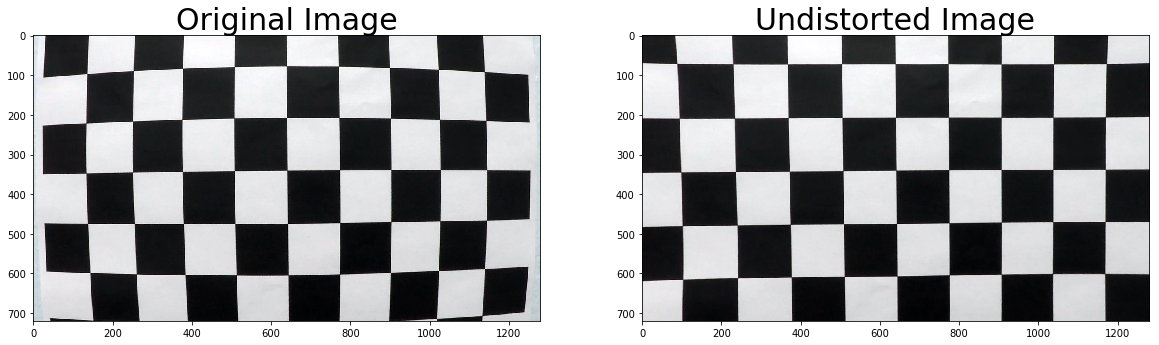

In [2]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

print(img_size)
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('outputs/undis_calibration1.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "outputs/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)




(1280, 720)


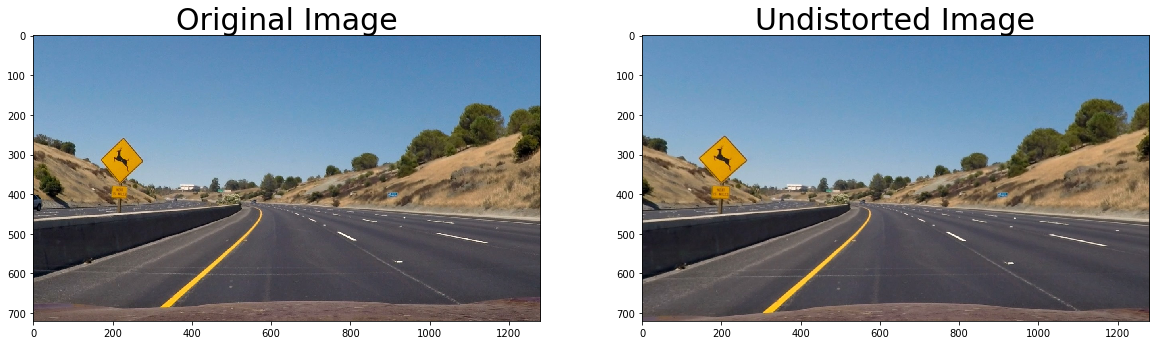

In [3]:
# Test undistortion on an image
img = cv2.imread('test_images/test2.jpg')
img_size = (img.shape[1], img.shape[0])

print(img_size)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('outputs/undis_calibration_test2.jpg',dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [5]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

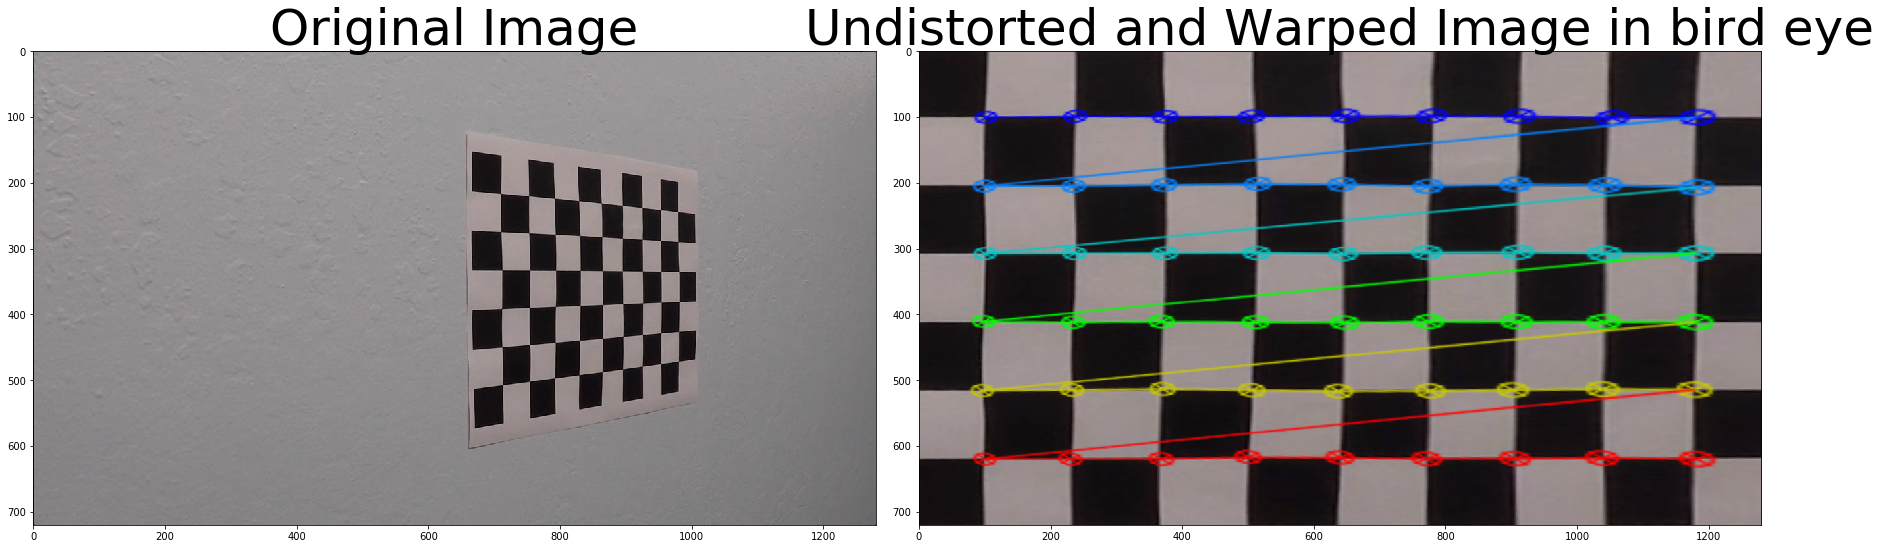

In [6]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in an image
img = cv2.imread('camera_cal/calibration8.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image in bird eye', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### binary_image_pipeline shows steps in the pipeline to get binary from origin image
step 1, the image is converted to HLS color space
step 2, take the derivative in x on l_channel
step 3, normalize the pixel value into range of (0, 255)
step 4, apply the threshold of s_thres(20, 100)
step 5, apply threshold(170, 255) on s_channel data
step 6, build combined color image where s_binary pixcel is of1 or l_channel pixel is 1


In [7]:
def select_yellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([20,60,60])
    upper = np.array([38,174, 250])
    mask = cv2.inRange(hsv, lower, upper)
    return mask

def select_white(image):
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(image, lower, upper)
    return mask

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [8]:
# Edit this function to create your own pipeline.
def binary_image_pipeline(image_in, s_thresh=(170, 255), sx_thresh=(20, 100)):
    
    img = np.copy(image_in)
    
    yellow_mask = select_yellow(img)
    white_mask  = select_white(img)
    
    combined_binary = np.zeros_like(yellow_mask)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    combined_binary[(yellow_mask !=0 ) | (white_mask != 0) | (sxbinary == 1)] = 1
    
    imshape = img.shape
    vertices = np.array([[(0,imshape[0]),(525, 432), (750, 432), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_region = region_of_interest(combined_binary, vertices)
    
    return masked_region



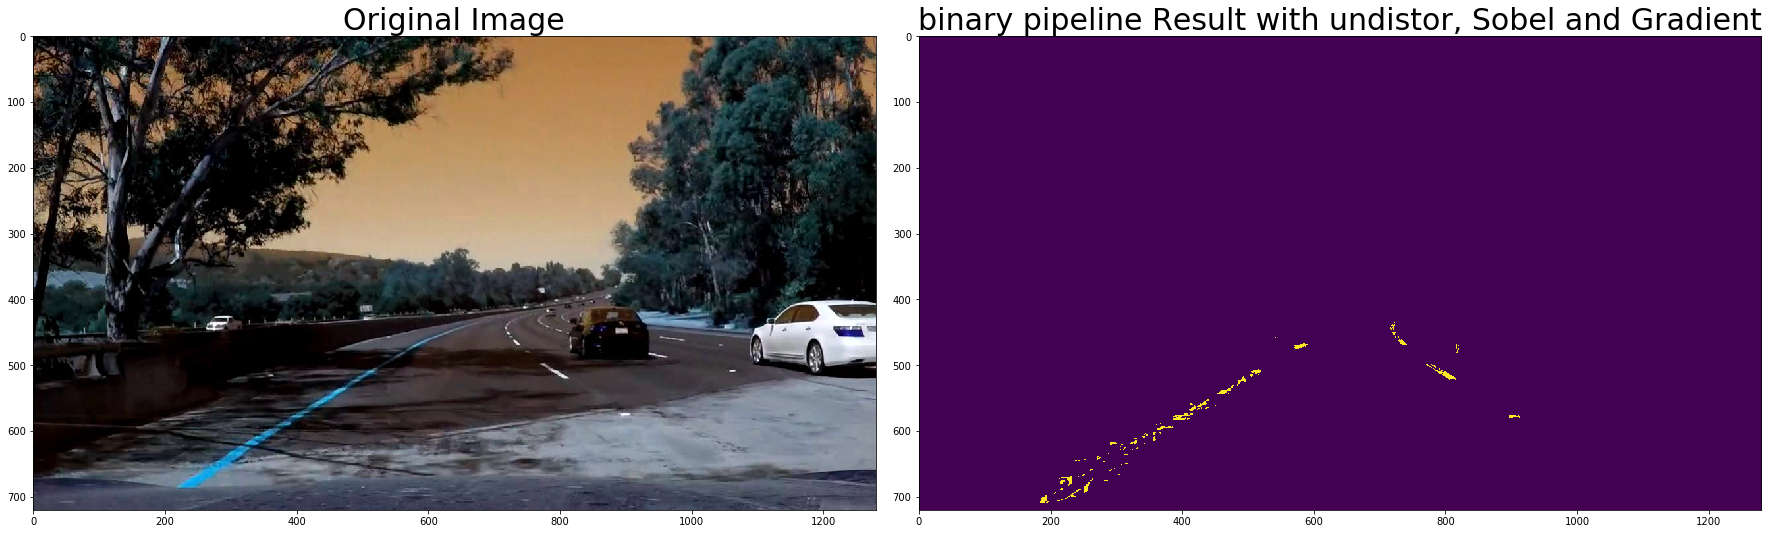

In [9]:
#following code is to show the binary image
image = cv2.imread('./frames/images1037.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_size = (image.shape[1], image.shape[0])
undist_image = cv2.undistort(image, mtx, dist, None, mtx)
sobel_grad = binary_image_pipeline(undist_image, (175, 255), (60, 180))
#cv2.imwrite('./outputs/images1057_sobel.jpg', sobel_grad)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(sobel_grad)
ax2.set_title('binary pipeline Result with undistor, Sobel and Gradient', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Following "warp" function calculate the perspective transform matrix with fixed src and fixed dest point.
The src points are obtained by locating the four points on the picture. calculate the mouse point offset of 78 in "shift+command+4" on Mac
The dest points are fixed around the two centers of histogram: 310 and 950
The four dot are plot back on the original image. the warped image as show as well. 

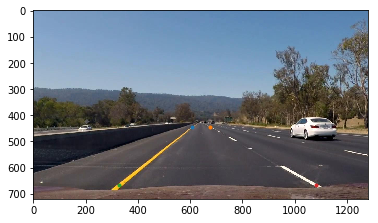

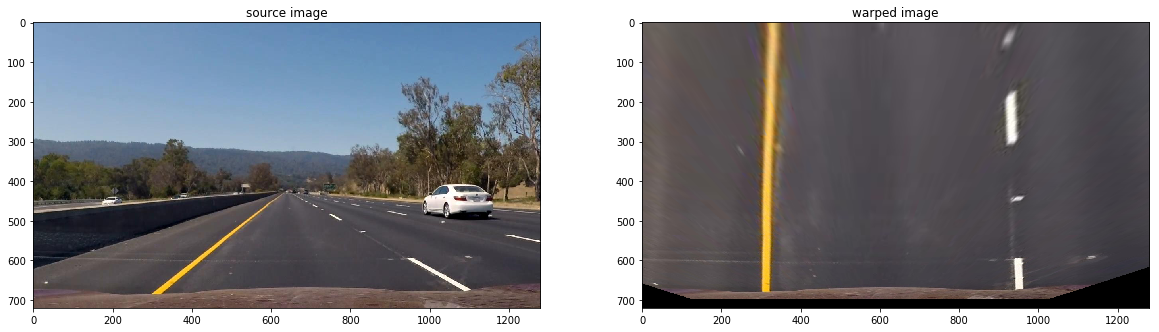

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# this ismage is extract from vidoe
img_to_warp = mpimg.imread('./frames/parall.jpg')

#img = mpimg.imread('./test_images/straight_lines1.jpg')

plt.imshow(img_to_warp)

plt.plot(607, 446, '.')
plt.plot(676, 446, '.')
plt.plot(329, 667, '.')
plt.plot(1081, 667, '.')

def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
    [[577, 469],
     [723, 469],
     [329, 667],
     [1081, 667]])
    dest = np.float32(
     [[320, 0],
      [920, 0],
      [310, 667],
     [950, 667]])
#     src = np.float32(
#         [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
#         [((img_size[0] / 6) - 10), img_size[1]],
#         [(img_size[0] * 5 / 6) + 60, img_size[1]],
#         [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
#     dest = np.float32(
#         [[(img_size[0] / 4), 0],
#         [(img_size[0] / 4), img_size[1]],
#         [(img_size[0] * 3 / 4), img_size[1]],
#         [(img_size[0] * 3 / 4), 0]])    
    M = cv2.getPerspectiveTransform(src, dest)
    Minv = cv2.getPerspectiveTransform(dest, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

warped_im, M, Minv = warp(img_to_warp)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('source image')
ax1.imshow(img_to_warp)
ax2.set_title('warped image')
ax2.imshow(warped_im)

### sliding window based lane finder algorithm. 
This portion of code is from the class content. modification is that rightx_base selection.
    if(rightx_base > 1100):
        rightx_base = 950
        

In [11]:
def frame_lane_detect(warped_in):
    
    binary_warped = warped_in
    #binary_warped = warped[:,:,2]
    import numpy as np
    import cv2
    import matplotlib.pyplot as plt5
    #%matplotlib qt5
    %matplotlib inline

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = 255*np.dstack((binary_warped, binary_warped, binary_warped)).astype('uint8')

    #out_img = 255*np.dstack((gray, gray, gray)).astype('uint8')

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    if(rightx_base > 1100 or rightx_base < 800):
        rightx_base = 950


    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    print(len(lefty))
    print(len(leftx))
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return out_img, left_fit, right_fit

In [12]:
# prediction based on previous ploy fit parameters. The function is found at: frame_lane_detect_calc
# This founction does not do the sliding window search on pixel for lane. instead, it use previous 
# ploy fit parameter to predict the lane and search pixel to the lane center +/- margin 100 pixels.
    
def frame_lane_detect_calc(left_fit, right_fit, binary_warped):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    #print('len leftx', len(leftx))
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return binary_warped, left_fit, right_fit

In [13]:
def curverads_centeroff(left_fit, right_fit, shape):
    '''
    # curverads_centeroff calculates the curverads for the left lane and right lane in meters. 
    # It also calcuate the lane offset to the center of lane in meter.
    # Inputs:
    #     left_fit: the left lane ploy fit coef
    #     right_fit: the right lane ploy fit coef
    #     shape: the image shape
    # Outputs:
    #     left_curverad: left lanes curverad in meter
    #     right_curverad: right lane curverad in meter
    #     lane_offset: the offset to the center of lane in meter
    '''

    ploty = np.linspace(0, shape[0]-1, shape[0] )
    y_eval = np.max(ploty)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space

    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    lane_offset = (1280/2 - (left_fitx[-1]+right_fitx[-1])/2)*xm_per_pix
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm', lane_offset, 'm')
    # Example values: 632.1 m    626.2 m
    
    return left_curverad, right_curverad, lane_offset

In [14]:

def project_detected_lane_back(left_fit, right_fit, frame, binary_warped, out_img):
    '''
    This function takes uses the ploy fit coefficiencies to draw the ploygon back to original image.
    Did not change this, use the material from class.
    '''
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (frame.shape[1], frame.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(frame, 1, newwarp, 0.3, 0)
    return result

In [15]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = np.array([0.0, 0.0, 0.0])  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0.0,0.0,0.0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # number to track how many frame has skipped
        self.skip = 0
        # indicate line needs to be update
        self.update = False


In [16]:
from collections import deque
class line_smoother:
    ''' 
    contain a deque collection of max length of 10 line records.
    if put function is called, it first check to see if queue is full. if it is full, pop one off queue.
    if the new line is detected, then add the new line coef to queue.
    The average_coef does the simple average of coef.
    '''
    def __init__(self):
        self.line_queue = deque(maxlen=10)
        self.smooth_coef = np.array([0, 0, 0], dtype='float')
        
    def put(self, line):
        if(len(self.line_queue) == 10) :
            self.line_queue.popleft()
        if(line.detected):
            self.line_queue.append(line)
        
    
    def average_coef(self):
        fit_coef = np.array([0, 0, 0], dtype='float')
        for item in self.line_queue:
            #print(item.current_fit)
            fit_coef += item.current_fit
        self.smooth_coef = fit_coef / len(self.line_queue)    
        return self.smooth_coef
    
# left_smoother = line_smoother ()
# for i in range(10) :
#     line = Line()
#     line.detected = True
#     line.current_fit = np.array([i,i,i])
#     left_smoother.put(line)

# left_smoother.average_coef()

In [17]:
# function to calcuate the average of coef based on past 10 line detection.
# first to check if the new coef has value or not. if it is, marked has valid coef. then put into smoother's queue.
# return the averaged coef
def smooth_coef(new_fit_coef, smoother):
    line = Line()
    line.current_fit = new_fit_coef
    if(len(new_fit_coef) > 0):
        line.detected = True
        
    smoother.put(line)
    
    return smoother.average_coef()


# create the two global line smoother, one for left land and one for right lane.
left_line_smoother = line_smoother()
right_line_smoother = line_smoother()

In [26]:
def txt_on_image(result, left_curverad, right_curverad, lane_offset, i):
    text_line = 'frame {}'.format(i)
    cv2.putText(result,text_line, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)

    text_line = 'left_curverad:{:8.2f} m'.format(left_curverad,)
    cv2.putText(result,text_line, (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)

    text_line = 'right_curverad:{:8.2f} m;'.format(right_curverad)
    cv2.putText(result,text_line, (50,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
    if(lane_offset < 0 ) :
        diff = ' left of'
    elif(lane_offset > 0):
        diff = ' right of'
    else:
        diff = ' at'
    text_line = 'lane_offset:{:4.2f} m'.format(abs(lane_offset)) + diff + ' center ' 
    cv2.putText(result,text_line, (50,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
    
    return result



### Main code boday

In [27]:
from moviepy.editor import VideoFileClip


def pipeline_process_frame(frame, mtx, dist, M, Minv, i):
    ''' 
    pipeline_process_frame is key video pipeline to process each frame in the video.
    it calls sequence of key action on the frame to obtained lane and draw it back to original image.
    Inputs: 
        frame: an image from video
        mtx  : camera calibration matrix
        dist : distortion matrix to undistort an image
        M    : perspective transform, M, given source and destination points
        Minv : inverse perspective transform, from dest to source transform
        i: the ith frame in image.
    Outputs:
        result: an image with found lane projected back on original image.
                print out the left and right curverad as well as offset to lane center in meter
                negative lane offset means to the center of right
    Here comes the main steps:
    1. undistort the image based on the camera calibration matrix mtx, distortion matrix dist.
    2. create binary image uses furction binary_image_pipeline with color transform and gradient x derivative
    3. create warped image based on the persepective transform to get bird eye image
    4. decide with algorithm to call to search lane for an image.
        a) if it is first frame or every 10 frames, then restart the window based lane search by calling frame_lane_detect
        b) else for current frame, use the privous frame's ploy fit search the pixels around prejected lane by calling
    5. smooth the lane coefficiencies with past 10 records.
    6. Warp the detected lane boundaries back onto the original image.
    7. calculate the curverad for both left and right lane.
    8. display the curverads and offset to original image
    9. return the final result image.
    '''
    img_size = (frame.shape[1], frame.shape[0])
    # step 1: undistor image
    undist_image = cv2.undistort(frame, mtx, dist, None, mtx)
    # step 2: create binary image with color transform and gradient
    sobel_grad = binary_image_pipeline(undist_image, (175, 255), (60, 180))
    # step 3: create warped image
    binary_warped = cv2.warpPerspective(sobel_grad, M, img_size)
    plt.imshow(binary_warped)
    # step 4: decide which algorithm to detect lane
    if((i == 0) or (i+1) % 4 == 0):
         #print( " slide window", i)
        out_img, left_fit, right_fit = frame_lane_detect(binary_warped)
    else:
        #print(" calc ", i)
        out_img, left_fit, right_fit = frame_lane_detect_calc(left_line_smoother.smooth_coef, right_line_smoother.smooth_coef, binary_warped)
    # step 5: smooth the lane with past 10 lane coefficiencies 
    left_fit = smooth_coef(left_fit, left_line_smoother)
    right_fit = smooth_coef(right_fit, right_line_smoother)
    # step 6: project the detect lane boundary back to original image
    result = project_detected_lane_back(left_fit, right_fit, undist_image, binary_warped, out_img)
    # step 7: calculate the left & right curverads and lane offset
    left_curverad, right_curverad, lane_offset = curverads_centeroff(left_fit, right_fit,img_size)
    # step 8: display left/right curverads and lane offset back to original image
    result = txt_on_image(result, left_curverad, right_curverad, lane_offset, i)
    
    return result



In [ ]:
from moviepy.editor import VideoFileClip

In [22]:
import os
#video_in = "challenge_video.mp4"
#video_out_dir = "./challenge/"

video_in = "project_video.mp4"
video_out_dir = "./basic/"

os.mkdir(video_out_dir)
orig_frame_out = video_out_dir + "orig_frames/"
os.mkdir(orig_frame_out)
output_frame = video_out_dir + "out_frames/"
os.mkdir(output_frame)

vertical_flip = lambda frame: frame # 'frame' is a numpy array
clip = VideoFileClip(video_in)
# transform the clip and write every frame as a jpeg
clip.fl_image(vertical_flip).to_images_sequence(orig_frame_out + "images%d.jpg")


[MoviePy] Writing frames ./basic/orig_frames/images%d.jpg.

1260it [01:04, 20.61it/s]                    

[MoviePy]: Done writing frames ./basic/orig_frames/images%d.jpg.



['./basic/orig_frames/images0.jpg',
 './basic/orig_frames/images1.jpg',
 './basic/orig_frames/images2.jpg',
 './basic/orig_frames/images3.jpg',
 './basic/orig_frames/images4.jpg',
 './basic/orig_frames/images5.jpg',
 './basic/orig_frames/images6.jpg',
 './basic/orig_frames/images7.jpg',
 './basic/orig_frames/images8.jpg',
 './basic/orig_frames/images9.jpg',
 './basic/orig_frames/images10.jpg',
 './basic/orig_frames/images11.jpg',
 './basic/orig_frames/images12.jpg',
 './basic/orig_frames/images13.jpg',
 './basic/orig_frames/images14.jpg',
 './basic/orig_frames/images15.jpg',
 './basic/orig_frames/images16.jpg',
 './basic/orig_frames/images17.jpg',
 './basic/orig_frames/images18.jpg',
 './basic/orig_frames/images19.jpg',
 './basic/orig_frames/images20.jpg',
 './basic/orig_frames/images21.jpg',
 './basic/orig_frames/images22.jpg',
 './basic/orig_frames/images23.jpg',
 './basic/orig_frames/images24.jpg',
 './basic/orig_frames/images25.jpg',
 './basic/orig_frames/images26.jpg',
 './basic/o

./basic/orig_frames/images0.jpg
15595
15595
./basic/orig_frames/images1.jpg
./basic/orig_frames/images2.jpg
./basic/orig_frames/images3.jpg
13735
13735
./basic/orig_frames/images4.jpg
./basic/orig_frames/images5.jpg
./basic/orig_frames/images6.jpg
./basic/orig_frames/images7.jpg
15051
15051
./basic/orig_frames/images8.jpg
./basic/orig_frames/images9.jpg
./basic/orig_frames/images10.jpg
./basic/orig_frames/images11.jpg
15142
15142
./basic/orig_frames/images12.jpg
./basic/orig_frames/images13.jpg
./basic/orig_frames/images14.jpg
./basic/orig_frames/images15.jpg
15342
15342
./basic/orig_frames/images16.jpg
./basic/orig_frames/images17.jpg
./basic/orig_frames/images18.jpg
./basic/orig_frames/images19.jpg
15413
15413
./basic/orig_frames/images20.jpg
./basic/orig_frames/images21.jpg
./basic/orig_frames/images22.jpg
./basic/orig_frames/images23.jpg
16815
16815
./basic/orig_frames/images24.jpg
./basic/orig_frames/images25.jpg
./basic/orig_frames/images26.jpg
./basic/orig_frames/images27.jpg
15

./basic/orig_frames/images225.jpg
./basic/orig_frames/images226.jpg
./basic/orig_frames/images227.jpg
11116
11116
./basic/orig_frames/images228.jpg
./basic/orig_frames/images229.jpg
./basic/orig_frames/images230.jpg
./basic/orig_frames/images231.jpg
11056
11056
./basic/orig_frames/images232.jpg
./basic/orig_frames/images233.jpg
./basic/orig_frames/images234.jpg
./basic/orig_frames/images235.jpg
10099
10099
./basic/orig_frames/images236.jpg
./basic/orig_frames/images237.jpg
./basic/orig_frames/images238.jpg
./basic/orig_frames/images239.jpg
8899
8899
./basic/orig_frames/images240.jpg
./basic/orig_frames/images241.jpg
./basic/orig_frames/images242.jpg
./basic/orig_frames/images243.jpg
6744
6744
./basic/orig_frames/images244.jpg
./basic/orig_frames/images245.jpg
./basic/orig_frames/images246.jpg
./basic/orig_frames/images247.jpg
9530
9530
./basic/orig_frames/images248.jpg
./basic/orig_frames/images249.jpg
./basic/orig_frames/images250.jpg
./basic/orig_frames/images251.jpg
8913
8913
./basi

./basic/orig_frames/images449.jpg
./basic/orig_frames/images450.jpg
./basic/orig_frames/images451.jpg
11311
11311
./basic/orig_frames/images452.jpg
./basic/orig_frames/images453.jpg
./basic/orig_frames/images454.jpg
./basic/orig_frames/images455.jpg
10866
10866
./basic/orig_frames/images456.jpg
./basic/orig_frames/images457.jpg
./basic/orig_frames/images458.jpg
./basic/orig_frames/images459.jpg
9803
9803
./basic/orig_frames/images460.jpg
./basic/orig_frames/images461.jpg
./basic/orig_frames/images462.jpg
./basic/orig_frames/images463.jpg
9173
9173
./basic/orig_frames/images464.jpg
./basic/orig_frames/images465.jpg
./basic/orig_frames/images466.jpg
./basic/orig_frames/images467.jpg
10869
10869
./basic/orig_frames/images468.jpg
./basic/orig_frames/images469.jpg
./basic/orig_frames/images470.jpg
./basic/orig_frames/images471.jpg
9393
9393
./basic/orig_frames/images472.jpg
./basic/orig_frames/images473.jpg
./basic/orig_frames/images474.jpg
./basic/orig_frames/images475.jpg
9129
9129
./basi

./basic/orig_frames/images673.jpg
./basic/orig_frames/images674.jpg
./basic/orig_frames/images675.jpg
11225
11225
./basic/orig_frames/images676.jpg
./basic/orig_frames/images677.jpg
./basic/orig_frames/images678.jpg
./basic/orig_frames/images679.jpg
9636
9636
./basic/orig_frames/images680.jpg
./basic/orig_frames/images681.jpg
./basic/orig_frames/images682.jpg
./basic/orig_frames/images683.jpg
11581
11581
./basic/orig_frames/images684.jpg
./basic/orig_frames/images685.jpg
./basic/orig_frames/images686.jpg
./basic/orig_frames/images687.jpg
11982
11982
./basic/orig_frames/images688.jpg
./basic/orig_frames/images689.jpg
./basic/orig_frames/images690.jpg
./basic/orig_frames/images691.jpg
6828
6828
./basic/orig_frames/images692.jpg
./basic/orig_frames/images693.jpg
./basic/orig_frames/images694.jpg
./basic/orig_frames/images695.jpg
11409
11409
./basic/orig_frames/images696.jpg
./basic/orig_frames/images697.jpg
./basic/orig_frames/images698.jpg
./basic/orig_frames/images699.jpg
12118
12118
./

./basic/orig_frames/images897.jpg
./basic/orig_frames/images898.jpg
./basic/orig_frames/images899.jpg
7233
7233
./basic/orig_frames/images900.jpg
./basic/orig_frames/images901.jpg
./basic/orig_frames/images902.jpg
./basic/orig_frames/images903.jpg
10678
10678
./basic/orig_frames/images904.jpg
./basic/orig_frames/images905.jpg
./basic/orig_frames/images906.jpg
./basic/orig_frames/images907.jpg
10571
10571
./basic/orig_frames/images908.jpg
./basic/orig_frames/images909.jpg
./basic/orig_frames/images910.jpg
./basic/orig_frames/images911.jpg
10290
10290
./basic/orig_frames/images912.jpg
./basic/orig_frames/images913.jpg
./basic/orig_frames/images914.jpg
./basic/orig_frames/images915.jpg
10262
10262
./basic/orig_frames/images916.jpg
./basic/orig_frames/images917.jpg
./basic/orig_frames/images918.jpg
./basic/orig_frames/images919.jpg
10518
10518
./basic/orig_frames/images920.jpg
./basic/orig_frames/images921.jpg
./basic/orig_frames/images922.jpg
./basic/orig_frames/images923.jpg
9042
9042
./

./basic/orig_frames/images1118.jpg
./basic/orig_frames/images1119.jpg
8020
8020
./basic/orig_frames/images1120.jpg
./basic/orig_frames/images1121.jpg
./basic/orig_frames/images1122.jpg
./basic/orig_frames/images1123.jpg
7094
7094
./basic/orig_frames/images1124.jpg
./basic/orig_frames/images1125.jpg
./basic/orig_frames/images1126.jpg
./basic/orig_frames/images1127.jpg
11139
11139
./basic/orig_frames/images1128.jpg
./basic/orig_frames/images1129.jpg
./basic/orig_frames/images1130.jpg
./basic/orig_frames/images1131.jpg
11924
11924
./basic/orig_frames/images1132.jpg
./basic/orig_frames/images1133.jpg
./basic/orig_frames/images1134.jpg
./basic/orig_frames/images1135.jpg
12381
12381
./basic/orig_frames/images1136.jpg
./basic/orig_frames/images1137.jpg
./basic/orig_frames/images1138.jpg
./basic/orig_frames/images1139.jpg
9565
9565
./basic/orig_frames/images1140.jpg
./basic/orig_frames/images1141.jpg
./basic/orig_frames/images1142.jpg
./basic/orig_frames/images1143.jpg
9139
9139
./basic/orig_f

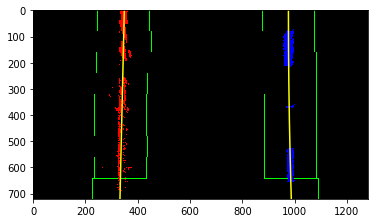

In [28]:
images = []

files = os.listdir(orig_frame_out)

for i in range(len(files)):
    filename = '{}images{}.jpg'.format(orig_frame_out, i)
    print(filename)
    my_frame = cv2.imread(filename)
    my_frame = cv2.cvtColor(my_frame, cv2.COLOR_BGR2RGB)
    my_frame = pipeline_process_frame(my_frame, mtx, dist, M, Minv, i)
    images.append(my_frame)
    
    my_frame = cv2.cvtColor(my_frame, cv2.COLOR_RGB2BGR)
    output_filename = output_frame + 'frame_{0:0>3}.jpg'.format(i)
    cv2.imwrite(output_filename, my_frame)


    
print("done with processing video frames:{}".format(i))

In [29]:

from moviepy.editor import ImageSequenceClip
video_file = 'p4_advanced_lane_smooth.mp4'
print("Creating video {}, FPS={}".format(video_file, 30))
clip = ImageSequenceClip(images, fps=30)
clip.write_videofile(video_file)

Creating video p4_advanced_lane_smooth.mp4, FPS=30
[MoviePy] >>>> Building video p4_advanced_lane_smooth.mp4
[MoviePy] Writing video p4_advanced_lane_smooth.mp4


100%|██████████| 1261/1261 [00:26<00:00, 48.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: p4_advanced_lane_smooth.mp4 



### following are testing code for each frame and debug problematic frame. the sequence is same as outlined pipeline_process_frame

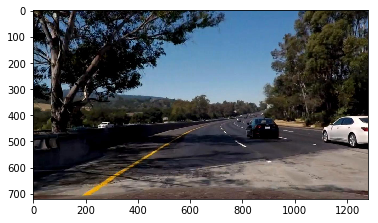

In [30]:
my_frame = cv2.imread(orig_frame_out + 'images1037.jpg')
img_size = (my_frame.shape[1], my_frame.shape[0])
undist_image = cv2.undistort(my_frame, mtx, dist, None, mtx)
#cv2.imshow('img', undist_image)
undist_image = cv2.cvtColor(undist_image, cv2.COLOR_BGR2RGB) # just for display purpose
plt.imshow(undist_image)

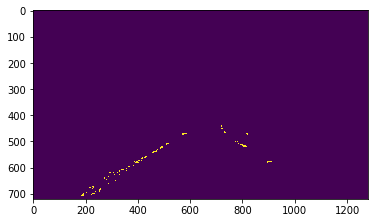

In [31]:
sobel_grad = binary_image_pipeline(undist_image, (175, 255), (60, 180))
plt.imshow(sobel_grad)

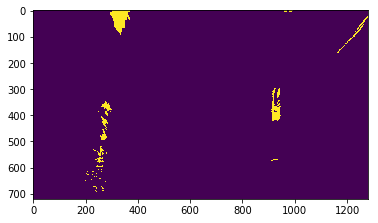

In [32]:
binary_warped = cv2.warpPerspective(sobel_grad, M, img_size)
plt.imshow(binary_warped)

(1280,)
[0 0 0 ..., 0 0 0]


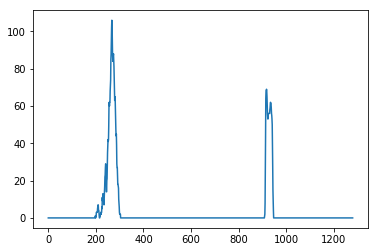

In [33]:
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
#histogram = np.sum(warped[:,:], axis=0)
plt.plot(histogram)
print(histogram.shape)
print(histogram)

(720, 1280)
7697
7697
[  1.19897576e-05  -1.51198343e-01   3.37024994e+02] [  2.23050977e-04  -2.08207531e-01   9.73641893e+02]


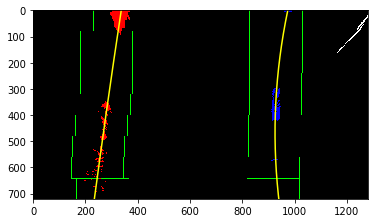

In [34]:

print(binary_warped.shape)
out_img, left_fit, right_fit = frame_lane_detect(binary_warped)
cv2.imwrite('./out_frames/out_img.jpg', out_img)
plt.imshow(out_img)

print(left_fit, right_fit)

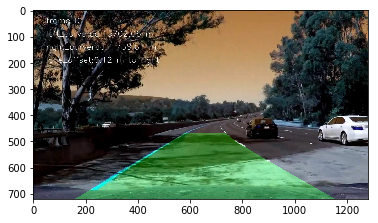

In [35]:
result = project_detected_lane_back(left_fit, right_fit, my_frame, binary_warped, out_img)
# step 7: calculate the left & right curverads and lane offset
left_curverad, right_curverad, lane_offset = curverads_centeroff(left_fit, right_fit,img_size)
# step 8: display left/right curverads and lane offset back to original image
i = 0
text_line = 'frame {}'.format(i)
cv2.putText(result,text_line, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)

text_line = 'left_curverad:{:8.2f} m'.format(left_curverad,)
cv2.putText(result,text_line, (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)

text_line = 'right_curverad:{:8.2f} m;'.format(right_curverad)
cv2.putText(result,text_line, (50,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)
if(lane_offset < 0 ) :
    diff = 'left'
elif(lane_offset > 0):
    diff = 'right'
else:
    diff = 'center'
text_line = 'lane_offset:{:4.2f} m'.format(abs(lane_offset)) + ' to ' + diff
cv2.putText(result,text_line, (50,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 1, cv2.LINE_AA)

cv2.imwrite('./out_frames/debug.jpg', result)
my_frame = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
plt.imshow(result)